# Data Preprocessing (Fragility Algo.)

1. Ran fragility analysis on SEEG data - log seizure times using Z
2. Run projection onto 2D/3D tensors, keep track of seizure times

This is done in comparison with the FFT to show in a result that:
- fragility > FFT in seizure detection using whole network data
- fragility can be formatted as input into the TVB Transfer Learning Pipeline

In [1]:
import sys
sys.path.append('../')
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
import fragility.util.utils as futil
import datainterface.patient as Pat
# from fragility.signalprocessing import frequencyanalysis
# from datainterface import readmat

# sys.path.append('/home/adamli/tng_tvb/')
# from tvbsim import visualize

import os
import time

import numpy as np
import pandas as pd
import scipy
import scipy.io

import peakdetect

sys.path.append('/Users/adam2392/Documents/tvb/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvbdata/')
sys.path.append('/Users/adam2392/Documents/tvb/_tvblibrary/')
# from tvb.simulator.lab import *
import tvbsim.util

import processing.util as util

from natsort import natsorted
import ntpath

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

In [3]:
import fragility.linearmodels.fragilitymodels

winsize = 250
stepsize = 125
radius = 1.5
perturbtype = 'C'

postprocessor = tvbsim.util.PostProcess([], [], [])
fragilitymodel = fragility.linearmodels.fragilitymodels.FragilityModel(winsize, stepsize, radius, perturbtype)

# define the data handler 
datahandler = util.DataHandler()
pca = PCA(n_components=2)
    
def _gettimepoints(numsignals, numwinsamps, numstepsamps):
    # create array of indices of window start times
    timestarts = np.arange(0, numsignals-numwinsamps+1, numstepsamps)
    # create array of indices of window end times
    timeends = np.arange(numwinsamps-1, numsignals, numstepsamps)
    # create the timepoints array for entire data array
    timepoints = np.append(timestarts.reshape(len(timestarts), 1), timeends.reshape(len(timestarts), 1), axis=1)
    return timepoints

INFO:fragility.linearmodels.fragilitymodels:Initialized perturbation model!
INFO:fragility.linearmodels.fragilitymodels:Initialized fragility model!


# 1 Load in Data (Either Simulated or Real

In [5]:
# Only analyzing 1 patient, specifically right now
patient = 'id001_ac'
patient = 'id013_pg'

expname = 'traindata'
datadir = os.path.join('/Volumes/ADAM LI/pydata/tvbforwardsim/', expname)
metadatadir = '/Volumes/ADAM LI/pydata/metadata/'    

# fragility results dir
resultsdir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fragility/', patient, 'seegpert/')

# expname = 'allregions_notmoved'
trainimagedir = os.path.join('/Volumes/ADAM LI/pydata/dnn/traindata/fragility/', patient, 'fragility_2d/')
if not os.path.exists(trainimagedir):
    os.makedirs(trainimagedir)


# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(resultsdir):
#     if 'allregions_sim' not in root:
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))

print(root)
print("\nrawdatadir is: ", datadir)
print("fragility results dir is: ", resultsdir)
print("training image dir is: ", trainimagedir)
print(len(datafiles))
# print(datafiles[50:])
# print(datafiles)

/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg

rawdatadir is:  /Volumes/ADAM LI/pydata/tvbforwardsim/traindata
fragility results dir is:  /Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/
training image dir is:  /Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/
63


In [ ]:
for idx, datafile in enumerate(datafiles):
    filename = path_leaf(datafile)
    rawdatafile = os.path.join(datadir, patient, path_leaf(datafiles[idx]).split('_pertmodel.npz')[0]+'.npz')
    
    # load in the raw data and zts
    data = np.load(rawdatafile, encoding='bytes')
    metadata = data['metadata'].item()
    zts = data['zts']
    
#     print(rawdatafile)
#     print(filename)
#     print(metadata.keys())
    # Extract location coordinates
    locations = metadata[b'seeg_xyz']
    try:
        patient_id = metadata[b'patient'].decode("utf-8") 
    except:
        patient = '_'.join(filename.split('_')[0:2])
    ezindices = metadata[b'ezindices']
    pzindices = metadata[b'pzindices']
    seeg_contacts = metadata[b'seeg_contacts']

    # get the actual seizure times and offsets
    allindices = np.append(ezindices.ravel(), pzindices.ravel(), axis=0)
    settimes = postprocessor.getonsetsoffsets(zts, 
                allindices, delta=0.2/5)
    seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)
    
    # load results data
    data = np.load(datafile, encoding='bytes')
    metadata = data['metadata'].item()
    fragmat = fragilitymodel.compute_fragilitymetric(data['pertmats'])
    print(data.keys())
    print(metadata.keys())
    print(fragmat.shape)
    
    # load time points, fragility
    timepoints = _gettimepoints(zts.shape[1], winsize, stepsize)
    print(timepoints.shape)
    
    filename = os.path.join(trainimagedir, 
             filename+'_'+str(idx)+'.npz')
    print(filename)
    
    ###################### PERFORM IMAGE MESHING ######################
    print("using pca to grid image")
    new_locs = pca.fit_transform(locations)
#     print(seizonsets)
#     print(seizoffsets)
    ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
    print(np.sum(ylabels)/len(ylabels))
    
    if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
        print("skipping ", datafile)
    else:
        # Tensor of size [samples, freqbands, W, H] containing generated images.
        image_tensor = datahandler.gen_images(new_locs, fragmat[:,np.newaxis,:], 
                                n_gridpoints=32, normalize=False, augment=False, 
                                pca=False, std_mult=0.1, edgeless=False)
    print(image_tensor.shape)

    # instantiate metadata hash table
    metadata = dict()
    metadata['seeg_contacts'] = seeg_contacts
    metadata['new_locs'] = new_locs
    metadata['ylabels'] = ylabels
    
    imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0]+'.npz')
    # save image and meta data
    np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

    print(datafile)
    print(fragmat.shape)
    print(seizonsets, seizoffsets)
    print('\n\n')
#     break

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.7_x0pz-1.99_pertmodel.npz_0.npz
using pca to grid image
0.0
(1439, 59)
Interpolating 1439/1439nterpolating 356/1439Interpolating 537/1439Interpolating 727/1439Interpolating 912/1439Interpolating 1024/1439Interpolating 1137/1439Interpolating 1278/1439(1439, 1, 32, 32)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.7_x0pz-1.99_pertmodel.npz
(59, 1439)
[3849.0, 9618.0, 11010.0, 17661.0, 17851.0, 24362.0, 28086.0, 30918.0, 36027.0, 37959.0, 44651.0, 45022.0, 51984.0, 52013.0, 58756.0, 63981.0, 65783.0, 72124.0, 72819.0

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.625_x0pz-1.98_pertmodel.npz_5.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 397/1439Interpolating 587/1439Interpolating 784/1439Interpolating 977/1439Interpolating 1171/1439Interpolating 1356/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.625_x0pz-1.98_pertmodel.npz
(59, 1439)
[2211.0, 4058.0, 11045.0, 11421.0, 17412.0, 19183.0, 23576.0, 30113.0, 30319.0, 36731.0, 38312.0, 42963.0, 49379.0, 49909.0, 55564.0, 57535.0, 61908.0, 66056.0, 68100.0, 74502.0, 74840.0, 80718.0, 83288.0

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.65_x0pz-2.02_pertmodel.npz_10.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 387/1439Interpolating 573/1439Interpolating 772/1439Interpolating 972/1439Interpolating 1169/1439Interpolating 1366/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.65_x0pz-2.02_pertmodel.npz
(59, 1439)
[8593.0, 9883.0, 15148.0, 21878.0, 22802.0, 28237.0, 34533.0, 34959.0, 41325.0, 43463.0, 47237.0, 53920.0, 54693.0, 60510.0, 62910.0, 67157.0, 73908.0, 76166.0, 80184.0, 86568.0, 86958.0, 92801.0, 99160.0,

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.7_x0pz-2.01_pertmodel.npz_15.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 391/1439Interpolating 573/1439Interpolating 772/1439Interpolating 961/1439Interpolating 1151/1439Interpolating 1286/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.7_x0pz-2.01_pertmodel.npz
(59, 1439)
[2273.0, 3823.0, 10994.0, 11973.0, 17890.0, 19909.0, 24338.0, 30735.0, 31058.0, 38101.0, 39305.0, 45049.0, 52115.0, 52159.0, 59065.0, 60265.0, 66026.0, 72678.0, 73137.0, 79399.0, 81157.0, 85974.0, 92820.0, 9

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.75_x0pz-2.0_pertmodel.npz_20.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 384/1439Interpolating 586/1439Interpolating 786/1439Interpolating 983/1439Interpolating 1179/1439Interpolating 1379/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.75_x0pz-2.0_pertmodel.npz
(59, 1439)
[2236.0, 3719.0, 11278.0, 12201.0, 18442.0, 20450.0, 25183.0, 32089.0, 32612.0, 39234.0, 41320.0, 45818.0, 52312.0, 52859.0, 59031.0, 61438.0, 66040.0, 73296.0, 73368.0, 80850.0, 81871.0, 87874.0, 90170.0, 9

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.775_x0pz-1.99_pertmodel.npz_25.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 398/1439Interpolating 598/1439Interpolating 797/1439Interpolating 1001/1439Interpolating 1203/1439Interpolating 1405/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.775_x0pz-1.99_pertmodel.npz
(59, 1439)
[3702.0, 9954.0, 11392.0, 18409.0, 18642.0, 25945.0, 31399.0, 32898.0, 39508.0, 39732.0, 46799.0, 48849.0, 53503.0, 59549.0, 60251.0, 67247.0, 67337.0, 73861.0, 76437.0, 80410.0, 85935.0, 87704.0, 94428

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.675_x0pz-1.98_pertmodel.npz_30.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 390/1439Interpolating 593/1439Interpolating 791/1439Interpolating 988/1439Interpolating 1172/1439Interpolating 1349/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.675_x0pz-1.98_pertmodel.npz
(59, 1439)
[2210.0, 3967.0, 11017.0, 11380.0, 17424.0, 19017.0, 23821.0, 30206.0, 30441.0, 37277.0, 38222.0, 44176.0, 46171.0, 50814.0, 55236.0, 57340.0, 64146.0, 64248.0, 70954.0, 72274.0, 77739.0, 80022.0, 84059.

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.8_x0pz-2.03_pertmodel.npz_35.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 398/1439Interpolating 596/1439Interpolating 797/1439Interpolating 997/1439Interpolating 1198/1439Interpolating 1394/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.8_x0pz-2.03_pertmodel.npz
(59, 1439)
[2190.0, 3564.0, 11391.0, 12350.0, 18819.0, 26127.0, 27163.0, 33316.0, 40739.0, 41700.0, 47673.0, 54800.0, 55057.0, 62211.0, 63918.0, 69494.0, 76583.0, 77670.0, 83680.0, 90725.0, 91230.0, 98003.0, 99848.0, 1

(1439, 1, 32, 32)9/1439nterpolating 196/1439Interpolating 591/1439Interpolating 794/1439Interpolating 993/1439Interpolating 1179/1439Interpolating 1375/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.75_x0pz-2.03_pertmodel.npz
(59, 1439)
[2187.0, 3588.0, 10903.0, 12200.0, 18105.0, 25188.0, 25383.0, 32095.0, 38480.0, 39995.0, 45031.0, 52147.0, 52389.0, 59120.0, 66195.0, 66337.0, 73580.0, 75016.0, 80854.0, 88038.0, 88793.0, 95047.0, 101840.0, 102421.0, 109089.0, 111088.0, 115912.0, 122879.0, 123056.0, 129880.0, 131505.0, 136352.0, 143105.0, 143697.0, 150025.0, 156344.0, 157374.0, 162848.0, 169996.0, 170654.0, 177036.0] [2187.0, 3588.0, 10903.0, 12200.0, 18105.0, 25188.0, 25383.0, 32095.0, 38480.0, 39995.0, 45031.0, 52147.0, 52389.0, 59120.0, 66195.0, 66337.0, 73580.0, 75016.0, 80854.0, 88038.0, 88793.0, 95047.0, 101840.0, 102421.0, 109089.0, 111088.0, 115912.0, 122879.0, 123056.0, 129880.0, 131505.0, 136352.0, 143105.0, 143697.0, 150025

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.625_x0pz-2.01_pertmodel.npz_46.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 397/1439Interpolating 596/1439Interpolating 779/1439Interpolating 976/1439Interpolating 1179/1439Interpolating 1382/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.625_x0pz-2.01_pertmodel.npz
(59, 1439)
[4056.0, 9866.0, 10947.0, 17568.0, 22230.0, 24132.0, 30220.0, 30682.0, 37049.0, 41521.0, 43552.0, 50006.0, 50010.0, 56292.0, 59432.0, 62854.0, 68898.0, 69615.0, 76032.0, 80756.0, 82699.0, 89182.0, 89235.

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.65_x0pz-2.03_pertmodel.npz_51.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 376/1439Interpolating 562/1439Interpolating 756/1439Interpolating 957/1439Interpolating 1159/1439Interpolating 1359/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.65_x0pz-2.03_pertmodel.npz
(59, 1439)
[8713.0, 10145.0, 15185.0, 21929.0, 22829.0, 27821.0, 34316.0, 34938.0, 41191.0, 43544.0, 47593.0, 54238.0, 54767.0, 60102.0, 66606.0, 67052.0, 73266.0, 79817.0, 80638.0, 86531.0, 88855.0, 93033.0, 99672.0

['delvecs', 'pertmats', 'metadata']
dict_keys([b'x0norm', b'patient', b'samplefreq', b'seeg_contacts', b'pz', b'seeg_xyz', b'ez', b'timepoints', b'offsettimes', b'regions_centers', b'regions', b'stepsize', b'winsize', b'perturbtype', b'radius', b'x0pz', b'onsettimes', b'pzindices', b'x0ez', b'ezindices', b'simparams'])
(59, 1439)
(1439, 2)
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/fragility_2d/id013_pg_sim_x0ez-1.675_x0pz-2.02_pertmodel.npz_56.npz
using pca to grid image
0.0
(1439, 59)
(1439, 1, 32, 32)9/1439nterpolating 396/1439Interpolating 597/1439Interpolating 796/1439Interpolating 999/1439Interpolating 1200/1439Interpolating 1402/1439
/Volumes/ADAM LI/pydata/dnn/traindata/fragility/id013_pg/seegpert/id013_pg/id013_pg_sim_x0ez-1.675_x0pz-2.02_pertmodel.npz
(59, 1439)
[2196.0, 4007.0, 11198.0, 12224.0, 18094.0, 24887.0, 25039.0, 31465.0, 33344.0, 38035.0, 44757.0, 44996.0, 50904.0, 57362.0, 57571.0, 64093.0, 65946.0, 70697.0, 77628.0, 77767.0, 84380.0, 85916.0, 90883.

In [73]:
imagefilename = os.path.join(trainimagedir, filename.split('.npz')[0]+'.npz')
print(imagefilename)

/Volumes/ADAM LI/pydata/dnn/traindata/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz


Baseline testing prediction of all seizure:  0.6275191104933981
Baseline testing prediction of all not seizure:  0.3724808895066018


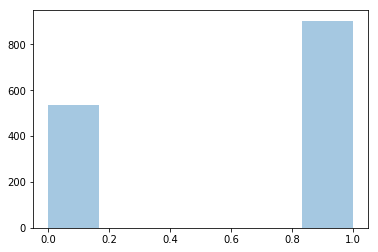

In [55]:
print("Baseline testing prediction of all seizure: ", np.sum(ylabels)/len(ylabels))
print("Baseline testing prediction of all not seizure: ", (len(ylabels)-np.sum(ylabels))/len(ylabels))

sns.distplot(ylabels, kde=False)

# fig = plt.figure()
# for i in range(len(seizonsets)):
#     xr = seizonsets[i], seizoffsets[i]
#     yr = y=i, i
# #     plt.plot(x=xr, y=yr)
#     plt.axvline(seizonsets[i], color='red')
#     plt.axvline(seizoffsets[i], color='black')
# plt.show()

(1439, 1, 32, 32)
1671.0 1671.0
(57560, 1)
7
55


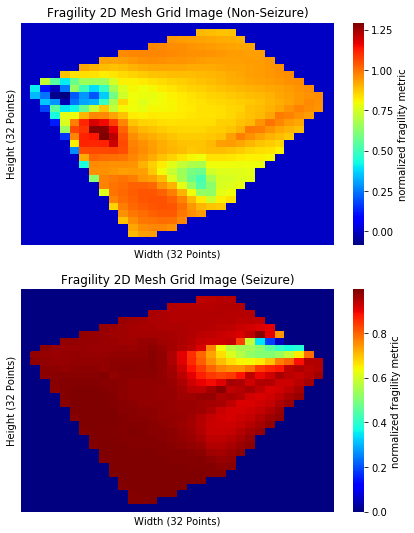

In [85]:
print(image_tensor.shape)
plt.figure(figsize=(7,9))
plt.subplot(211)
sns.heatmap(image_tensor[5,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Non-Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

plt.subplot(212)
sns.heatmap(image_tensor[12,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

print(seizonsets[0], seizoffsets[0])
print(ylabels.shape)
print(np.where(ylabels==0)[0][7])
print(np.where(ylabels==1)[0][7])

In [37]:
sns.heatmap(fragmat_2d, cmap='jet')
plt.colorbar()
plt.show()

img = Image.fromarray(data, 'RGB')
img.save('test.png')

w, h = 512, 512
data = np.random.rand(h, w, 3)
data[256, 256] = [255, 0, 0]
# img = Image.fromarray(data, 'RGB')

# data = np.divide(data, 255.)
print(np.min(data.ravel()), np.max(data.ravel())) 
img = Image.fromarray(data, 'RGB')
img.save('test.png')

img = Image.open('test.png')
print(img.size)
plt.imshow(img)

0.0 255.0


# Concatenate All 2D Images Into 1 Large Dataset

In [76]:
# Get ALL datafiles from all downstream files
trainfiles = []
for root, dirs, files in os.walk(trainimagedir):
    for file in files:
        trainfiles.append(os.path.join(root, file))
print("Train data dir is: ", datadir)
print("In traindatadir there are this many training files: ", len(trainfiles))

Train data dir is:  /Volumes/ADAM LI/pydata/tvbforwardsim/traindata
In traindatadir there are this many training files:  40


In [77]:
for idx, datafile in enumerate(trainfiles):
    data = np.load(datafile)
    imagetensor = data['image_tensor']
    metadata = data['metadata'].item()
    labels = metadata['ylabels']
    
    if idx == 0:
        ylabels = labels
        alltensors = imagetensor.reshape((imagetensor.shape[0], -1))
        print(datafile)
        print(imagetensor.shape)
        print(metadata.keys())
    else:
        alltensors = np.concatenate((alltensors, imagetensor.reshape((imagetensor.shape[0], -1))), axis=0)
        ylabels = np.concatenate((ylabels, metadata['ylabels']),axis=0)  

/Volumes/ADAM LI/pydata/dnn/traindata/fragility/fragility_2d/id001_ac_sim_x0ez-1.675_x0pz-2.04_pertmodel.npz
(1439, 1, 32, 32)
dict_keys(['seeg_contacts', 'new_locs', 'ylabels'])


In [115]:
print(sys.getsizeof(alltensors) * 1.0e-9) 
print(alltensors.shape)
print(ylabels.shape)

filename = os.path.join(trainimagedir, 'allimages_fragility2d.npz')
# np.savez_compressed(filename, images=alltensors, labels=ylabels)

0.47153163200000003
(57560, 1024)
(4943, 1)


In [118]:
data = np.load(filename)
ylabels = data['labels']

Baseline testing prediction of all seizure:  0.6854586518415566
Baseline testing prediction of all not seizure:  0.31454134815844337


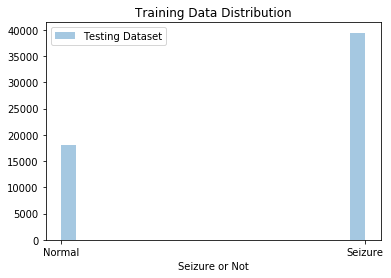

In [119]:
print("Baseline testing prediction of all seizure: ", np.sum(ylabels)/len(ylabels))
print("Baseline testing prediction of all not seizure: ", (len(ylabels)-np.sum(ylabels))/len(ylabels))

sns.distplot(ylabels, kde=False, axlabel='Seizure or Not', label='Testing Dataset')
ax=plt.gca()
ax.set_title('Training Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

In [83]:
print(np.sum(ylabels) - (len(ylabels) - np.sum(ylabels)))
print(len(ylabels) - np.sum(ylabels))


21350.0
18105.0


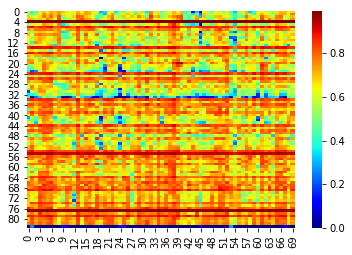

In [112]:
sns.heatmap(fragmat[:,0:70], cmap='jet')

# Convert Real Data Into Image

In [5]:
patient = 'id001_ac_sz2'
# patient = 'id013_pg_sz1'
patid = patient[0:patient.find('sz')-1]
seizid = patient[patient.find('sz'):]

datadir = '/Volumes/ADAM LI/pydata/convertedtng'

chanfile =  os.path.join(datadir,  patient, patient + '_chans.csv')
headerfile = os.path.join(datadir,  patient, patient + '_headers.csv')
annotationsfile = os.path.join(datadir,  patient, patient + '_annotations.csv')

################################ 1. LOAD DATA ###########################
# instantiate a datainterface object to analyze data
patieeg = Pat.PatientIEEG(patient, clinoutcome=None, engelscore=None, logfile=None)
# get relevant channel data
included_chans, onsetchans, clinresult = fragility.util.utils.returnindices(patid, seizid)

# set metadata to be used in analysis
patieeg.setincludedchans(included_chans)
patieeg.setmetadata_fromfile(headersfile=headerfile)
patieeg.setchannels_fromfile(channelsfile=chanfile)
patieeg.setannotations_fromfile(annotationsfile=annotationsfile)

INFO:datainterface.patient:Initialized Patient IEEG object. Should run channels, metadata and annotations next!
INFO:datainterface.patient:Ran setup of meta data!
INFO:datainterface.patient:Ran setup of channels data!
INFO:datainterface.patient:Ran setup of annotations data!


In [6]:
metadatadir = os.path.join('/Volumes/ADAM LI/pydata/metadata/', patid)    
# or get labels from seeg metadata
# read in seeg file
seeg = pd.read_csv(os.path.join(metadatadir, "seeg.txt"), 
                   names=['x', 'y', 'z'], 
                   delim_whitespace=True)
seeg_labels = seeg.index
seeg_xyz = seeg.as_matrix()
locations = seeg_xyz
seeg_contacts = list(seeg_labels)

removeset = []
if 'id013' in patient:
    # remove these chanlabels from i013_pg
    removeset = ['A15', 'B2', 'B3', 'B8', 'C9', 'C10', 'OP10']
elif 'id001' in patient:
    removeset = ["TP5", "CC11", "OR'10", "OR'13", "OR'14", "OR'15"]

chaninds = [i for i,chan in enumerate(seeg_labels) \
        if chan not in removeset]
#     print(seeg_contacts[chaninds])
print(seeg_labels[chaninds])
print(seeg_labels[chaninds].shape)
seeg_labels = seeg_labels[chaninds]
locations = locations[chaninds,:]
print(locations.shape)

Index(['OR1', 'OR2', 'OR3', 'OR4', 'OR5', 'OR6', 'OR7', 'OR8', 'OR9', 'OR10',
       'OR11', 'OR12', 'OR13', 'OR14', 'OR'1', 'OR'2', 'OR'3', 'OR'4', 'OR'5',
       'OR'6', 'OR'7', 'OR'8', 'OR'9', 'OR'11', 'OR'12', 'TBP1', 'TBP2',
       'TBP3', 'TBP4', 'TBP5', 'TBP6', 'TBP7', 'TBP8', 'TBP9', 'TP1', 'TP2',
       'OF1', 'OF2', 'OF3', 'OF4', 'CC1', 'CC2', 'CC3', 'CC4', 'CC5', 'CC6',
       'CC7', 'CC8', 'CC9', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PM7',
       'PM8', 'PM9', 'CR1', 'CR2', 'CR3', 'CR4', 'CR5', 'CR6', 'CR7', 'CR8',
       'CR9'],
      dtype='object')
(67,)
(67, 3)


In [7]:
testfile = '/Volumes/ADAM LI/pydata/dnn/testdata/fragility/pert/' + patient + '/'\
 + patient + 'pertmodel.npz'
data = np.load(testfile, encoding='bytes')
seizonsets = [patieeg.onset_time]
seizoffsets = [patieeg.offset_time]

# load results data
metadata = data['metadata'].item()
fragmat = fragilitymodel.compute_fragilitymetric(data['pertmats'])
# load time points, fragility
timepoints = data['timepoints']

# for id001_ac throw out first window
fragmat = fragmat[:,1:]
timepoints = timepoints[1:,:]

# print(data.keys())
# print(metadata.keys())
print("fragility mat shape is: ", fragmat.shape)
print("timepoints shape is: ", timepoints.shape)

###################### PERFORM IMAGE MESHING ######################
print("using pca to grid image")
new_locs = pca.fit_transform(locations)
#     print(seizonsets)
#     print(seizoffsets)
ylabels = datahandler.computelabels(np.multiply(seizonsets,500),np.multiply(seizoffsets,500), timepoints)
# ylabels = ylabels[1:]
print(np.sum(ylabels)/len(ylabels))

if len(seizonsets) <= 1 and seizonsets[0] == np.nan:
    print("skipping ", datafile)
else:
    # Tensor of size [samples, freqbands, W, H] containing generated images.
    image_tensor = datahandler.gen_images(new_locs, fragmat[:,np.newaxis,:], 
                            n_gridpoints=32, normalize=False, augment=False, 
                            pca=False, std_mult=0.1, edgeless=False)
print(image_tensor.shape)
print(ylabels.shape)


/Users/adam2392/Documents/fragility_analysis/fragility/linearmodels/fragilitymodels.py:426: RuntimeWarning: invalid value encountered in true_divide
  np.max(minnormpertmat[:, icol])


fragility mat shape is:  (67, 4944)
timepoints shape is:  (4944, 2)
using pca to grid image
0.588794498381877
(4944, 67)
Interpolating 4944/4944nterpolating 363/4944Interpolating 542/4944Interpolating 913/4944Interpolating 1096/4944Interpolating 1282/4944Interpolating 1457/4944Interpolating 1621/4944Interpolating 1799/4944Interpolating 1982/4944Interpolating 2159/4944Interpolating 2318/4944Interpolating 2498/4944Interpolating 2682/4944Interpolating 2865/4944Interpolating 3041/4944Interpolating 3223/4944Interpolating 3402/4944Interpolating 3584/4944Interpolating 3762/4944Interpolating 3932/4944Interpolating 4112/4944Interpolating 4293/4944Interpolating 4464/4944Interpolating 4636/4944Interpolating 4815/4944(4944, 1, 32, 32)
(4944, 1)


In [11]:
# instantiate metadata hash table
metadata = dict()
metadata['seeg_contacts'] = seeg_contacts
metadata['new_locs'] = new_locs
metadata['ylabels'] = ylabels

imagefilename = os.path.join('/Users/adam2392/Downloads/', patient+'_testimages.npz')
# save image and meta data
np.savez(imagefilename, image_tensor=image_tensor, metadata=metadata)

print(imagefilename)
print(fragmat.shape)
print(seizonsets, seizoffsets)
print('\n\n')

/Users/adam2392/Downloads/id001_ac_sz2_testimages.npz
(67, 4944)
[171.7539062] [532.7539062]





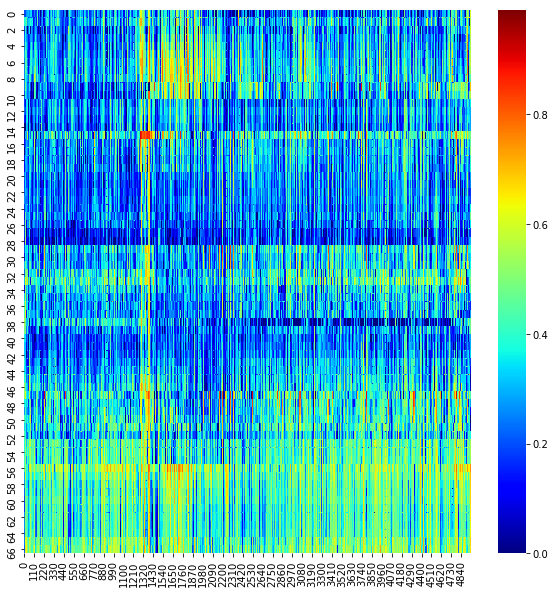

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(fragmat, cmap='jet')

(4944, 1, 32, 32)
171.7539062 532.7539062
(4944, 1)
[   0    1    2 ... 4941 4942 4943]
[1383 1384 1385 ... 4291 4292 4293]


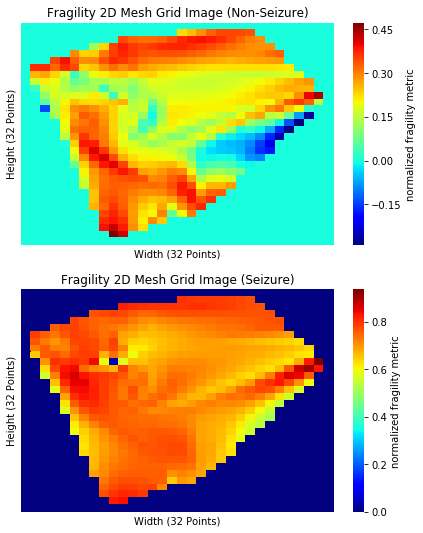

In [10]:
print(image_tensor.shape)
plt.figure(figsize=(7,9))
plt.subplot(211)
sns.heatmap(image_tensor[300,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Non-Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

plt.subplot(212)
sns.heatmap(image_tensor[1400,...].squeeze(), cmap='jet', cbar_kws={'label': 'normalized fragility metric'})
plt.title('Fragility 2D Mesh Grid Image (Seizure)')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Height (32 Points)')
ax.set_xlabel('Width (32 Points)')

print(seizonsets[0], seizoffsets[0])
print(ylabels.shape)
print(np.where(ylabels==0)[0])
print(np.where(ylabels==1)[0])

In [37]:
print(seizonsets, seizoffsets)

print(2*60+51)

[171.7539062] [532.7539062]
171


In [22]:
print(timepoints[0:5,:])

[[ 62 186]
 [124 248]
 [186 310]
 [248 372]
 [310 434]]


In [23]:
#     print(seizoffsets)
ylabels = datahandler.computelabels(np.multiply(seizonsets,500),np.multiply(seizoffsets,500), timepoints)
ylabels = ylabels[1:]
print(np.sum(ylabels)/len(ylabels))
print(ylabels.shape)
print(np.where(ylabels==0)[0])
print(np.where(ylabels==1)[0])

0.4748580697485807
(2466, 1)
[   0    1    2 ... 2463 2464 2465]
[ 667  668  669 ... 1835 1836 1837]


In [22]:
print(np.multiply(seizonsets,500))
print(np.multiply(seizoffsets,500))

[41546.875]
[114187.5]


In [41]:
print(timepoints)
print(306688/500)
print(613/60)

[[    62    186]
 [   124    248]
 [   186    310]
 ...
 [306404 306528]
 [306466 306590]
 [306528 306652]]
613.376
10.216666666666667


In [17]:
test = np.ones((5,2))
print(test)

test = np.delete(test, np.append([2,3], [0]), axis=0)
print(test)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
